In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import requests
from io import BytesIO

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

train_df = pd.read_excel("/content/train(1).xlsx")
test_df = pd.read_excel("/content/test2.xlsx")
train_df.head()


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,9117000170,20150505T000000,268643,4,2.25,1810,9240,2.0,0,0,...,7,1810,0,1961,0,98055,47.4362,-122.187,1660,9240
1,6700390210,20140708T000000,245000,3,2.50,1600,2788,2.0,0,0,...,7,1600,0,1992,0,98031,47.4034,-122.187,1720,3605
2,7212660540,20150115T000000,200000,4,2.50,1720,8638,2.0,0,0,...,8,1720,0,1994,0,98003,47.2704,-122.313,1870,7455
3,8562780200,20150427T000000,352499,2,2.25,1240,705,2.0,0,0,...,7,1150,90,2009,0,98027,47.5321,-122.073,1240,750
4,7760400350,20141205T000000,232000,3,2.00,1280,13356,1.0,0,0,...,7,1280,0,1994,0,98042,47.3715,-122.074,1590,8071


In [2]:
import os
os.listdir("/content")




['.config', 'test2.xlsx', 'train(1).xlsx', 'sample_data']

In [3]:
train_df = train_df.dropna()
test_df = test_df.dropna()


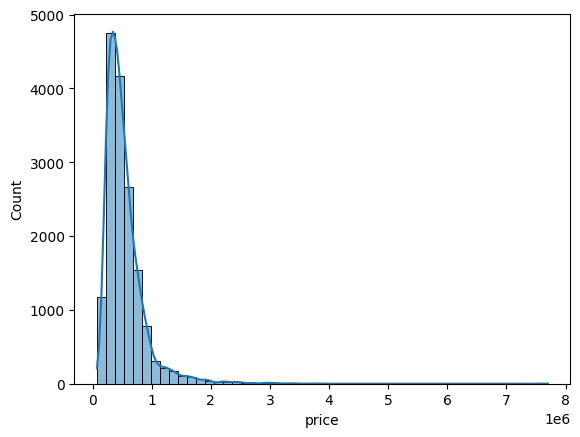

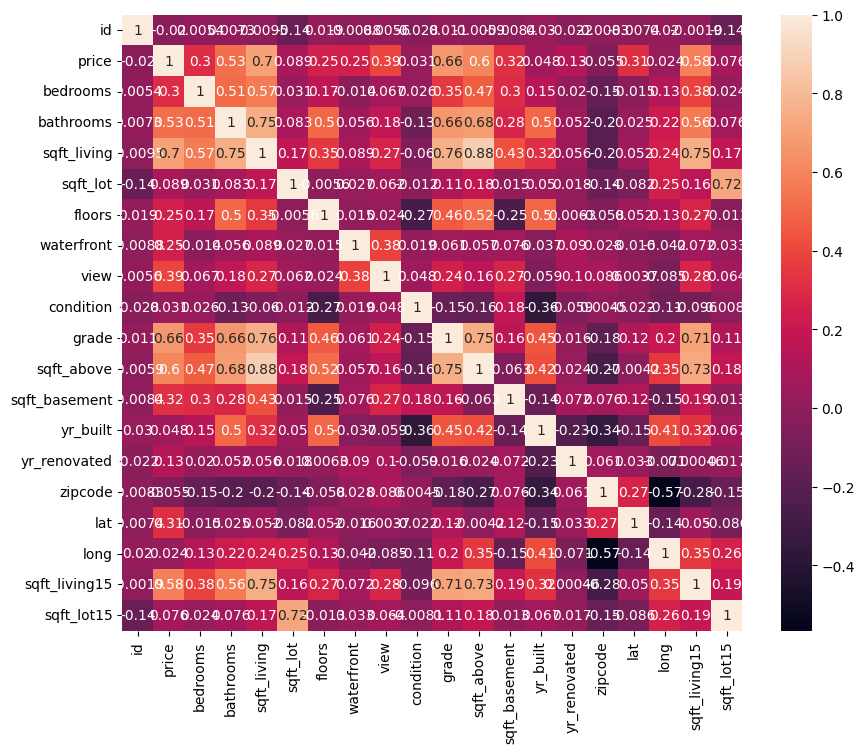

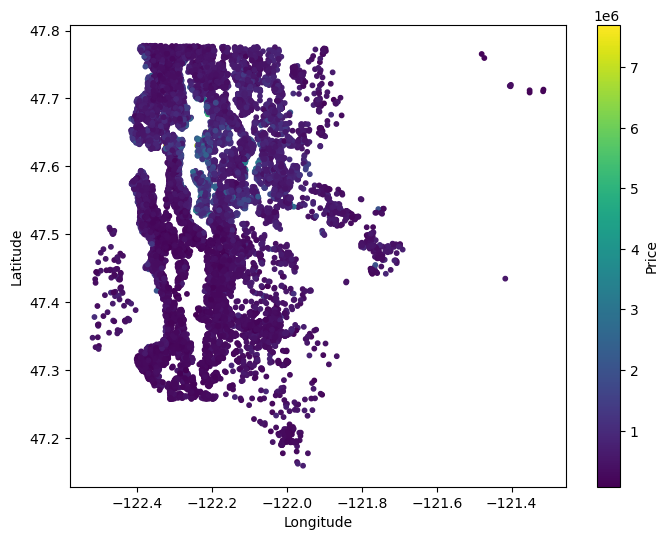

In [4]:
numeric_df = train_df.select_dtypes(include=np.number)

sns.histplot(numeric_df['price'], bins=50, kde=True)
plt.show()

plt.figure(figsize=(10,8))
sns.heatmap(numeric_df.corr(), annot=True)
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(numeric_df['long'], numeric_df['lat'], c=numeric_df['price'], cmap='viridis', s=10)
plt.colorbar(label='Price')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [6]:
os.makedirs("/content/images/train", exist_ok=True)
os.makedirs("/content/images/test", exist_ok=True)


In [7]:
import requests
from PIL import Image
from io import BytesIO

MAPBOX_TOKEN = "pk.eyJ1IjoiYXJrYXByYXZhYmlzd2FzOTE5IiwiYSI6ImNtazFjazh5YTA0anEzcHF3aTBmMWRvbTUifQ.hiIJnRAGojipNCvi2uuDMg"

def fetch_image(lat, lon, path):
    url = (
        f"https://api.mapbox.com/styles/v1/mapbox/satellite-v9/static/"
        f"{lon},{lat},18/224x224"
        f"?access_token={MAPBOX_TOKEN}"
    )
    r = requests.get(url)
    if r.status_code == 200:
        img = Image.open(BytesIO(r.content)).convert("RGB")
        img.save(path)



In [7]:
import os

os.makedirs("images/train", exist_ok=True)


In [8]:
import time
import os

os.makedirs("images/train", exist_ok=True)

for i, row in train_df.head(5000).iterrows():
    img_path = f"images/train/{row['id']}.png"
    if not os.path.exists(img_path):
        fetch_image(row['lat'], row['long'], img_path)
        time.sleep(0.03)



In [11]:
import os

img_path = "images/train/9117000170.png"
print(os.path.exists(img_path))


True


In [19]:
import os
os.makedirs("images/test_1", exist_ok=True)

for i, row in test_df.head(500).iterrows():
    fetch_image(row["lat"], row["long"], f"images/test_1/{row['id']}.png")
    time.sleep(0.03)

Image not found: 9136103027
Image not found: 3286800370
Image not found: 2922701085


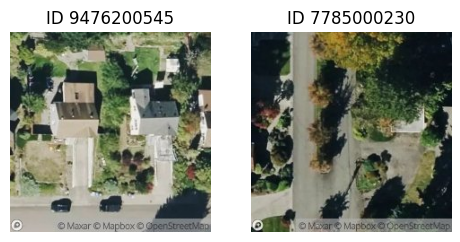

In [16]:
import random
import os
import matplotlib.pyplot as plt
from PIL import Image

idx = random.sample(list(train_df['id']), 5)  # pick 5 random IDs

plt.figure(figsize=(15,5))
for j, img_id in enumerate(idx):
    img_path = f"images/train/{img_id}.png"
    if os.path.exists(img_path):
        img = Image.open(img_path)
        plt.subplot(1,5,j+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"ID {img_id}")
    else:
        print(f"Image not found: {img_id}")
plt.show()


In [8]:
train_df.head(5000).to_csv("train_clean(1).csv", index=False)
test_df.head(500).to_csv("test_clean(1).csv", index=False)


In [21]:
import os

os.makedirs("images_train_new", exist_ok=True)
os.makedirs("images_test_new", exist_ok=True)


In [22]:
import shutil

train_source_dir = "images/train"
train_dest_dir = "images_train_new"

for f in os.listdir(train_source_dir):
    full_path = os.path.join(train_source_dir, f)
    if os.path.isfile(full_path):
        shutil.copy(full_path, train_dest_dir)


In [23]:
test_source_dir = "images/test_1"
test_dest_dir = "images_test_new"

for f in os.listdir(test_source_dir):
    full_path = os.path.join(test_source_dir, f)
    if os.path.isfile(full_path):
        shutil.copy(full_path, test_dest_dir)


In [25]:
import shutil

shutil.make_archive("images_train_new", 'zip', "images_train_new")
shutil.make_archive("images_test_new", 'zip', "images_test_new")


'/content/images_test_new.zip'

In [26]:
from google.colab import files

files.download("images_train_new.zip")
files.download("images_test_new.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
train_df = pd.read_csv("train_clean(1).csv")

In [11]:
print("Dataset shape:", train_df.shape)
print("\nMissing values:\n", train_df.isnull().sum())
print("\nStatistical summary:\n", train_df.describe())

Dataset shape: (5000, 21)

Missing values:
 id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

Statistical summary:
                  id         price     bedrooms    bathrooms   sqft_living  \
count  5.000000e+03  5.000000e+03  5000.000000  5000.000000   5000.000000   
mean   4.557148e+09  5.380520e+05     3.378000     2.106250   2062.553000   
std    2.887545e+09  3.845823e+05     1.008424     0.770352    907.719621   
min    1.200019e+06  7.500000e+04     0.000000     0.000000    290.000000   
25%    2.025775e+09  3.200000e+05     3.000000     1.500000   1420.000000   
50%    3.905086e+09  4.500000e+05     3.000000     2.250000

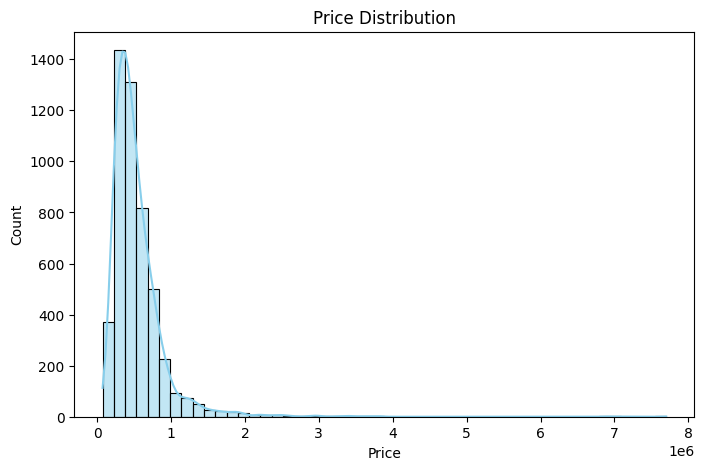

In [12]:
plt.figure(figsize=(8,5))
sns.histplot(train_df['price'], bins=50, kde=True, color='skyblue')
plt.title("Price Distribution")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()

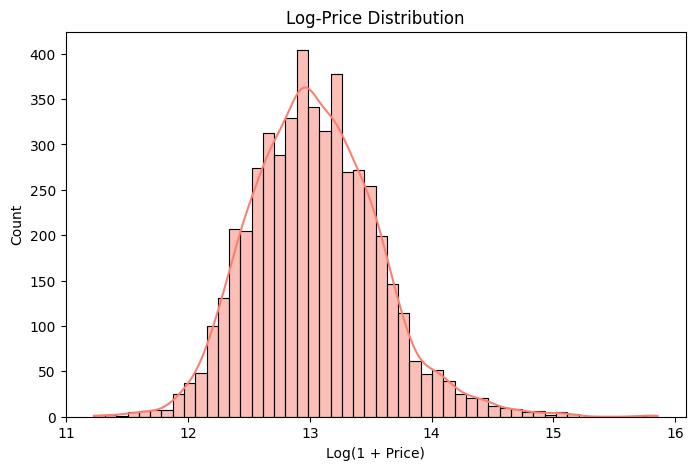

In [13]:
plt.figure(figsize=(8,5))
sns.histplot(np.log1p(train_df['price']), bins=50, kde=True, color='salmon')
plt.title("Log-Price Distribution")
plt.xlabel("Log(1 + Price)")
plt.ylabel("Count")
plt.show()

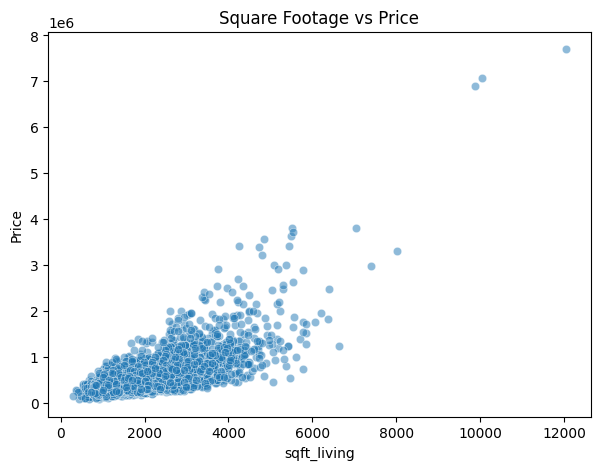

In [14]:
plt.figure(figsize=(7,5))
sns.scatterplot(x='sqft_living', y='price', data=train_df, alpha=0.5)
plt.title("Square Footage vs Price")
plt.xlabel("sqft_living")
plt.ylabel("Price")
plt.show()

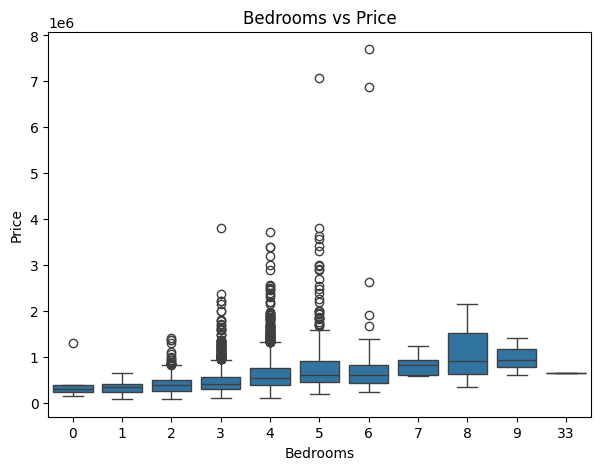

In [16]:
plt.figure(figsize=(7,5))
sns.boxplot(x='bedrooms', y='price', data=train_df)
plt.title("Bedrooms vs Price")
plt.xlabel("Bedrooms")
plt.ylabel("Price")
plt.show()

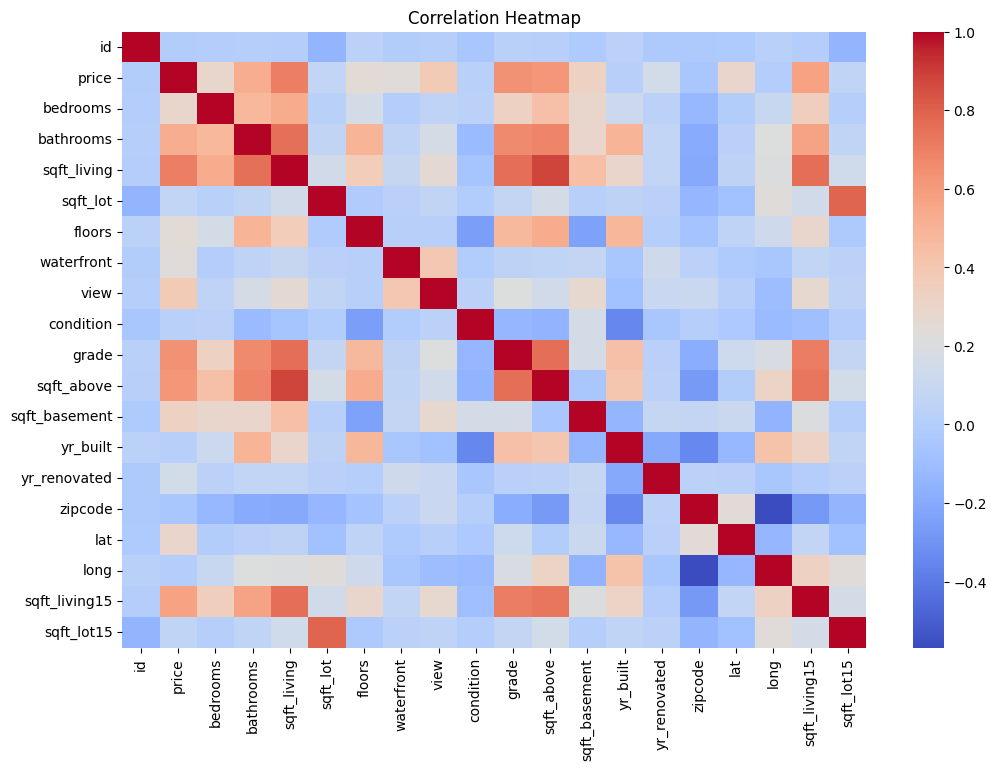

In [18]:
plt.figure(figsize=(12,8))
corr = train_df.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()
